## Working with the brige from previous task(C60)

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import trimesh
import open3d as o3d
import matplotlib.pyplot as plt
from data_load import correct_meshroom_extrinsics, get_image_data_from_json, get_camera_intrinsics_from_json
from mesh_utils import slice_mesh_with_fuse, create_masks_from_meshes, draw_mask_on_img
from visualisation import visualize_results, visualize_results_interactive


def rotation_matrix_to_euler_angles(R):
    """Converts a rotation matrix to Euler angles (yaw, pitch, roll)."""

    sy = np.sqrt(R[0, 0] ** 2 + R[1, 0] ** 2)
    singular_case = sy < 1e-6

    if not singular_case:
        yaw = np.arctan2(R[1, 0], R[0, 0])
        pitch = -np.arcsin(R[2, 0])
        roll = np.arctan2(R[2, 1], R[2, 2])
    else:
        yaw = np.arctan2(-R[1, 2], R[0, 2])
        pitch = np.pi / 2 if R[2, 0] > 0 else -np.pi / 2
        roll = 0

    return yaw, pitch, roll

plt.rcParams['figure.figsize'] = [12.5, 7.5]

### Creating decimated model fo faster work

In [2]:
prepare_decimated_model = False
if prepare_decimated_model: 
    mesh = trimesh.load("../Bridge-Seg/data/Step_B_C60/C60_scaled_cleaned.obj", force='mesh')
    if not mesh.is_watertight:
        mesh.fix_normals()

    mesh = mesh.subdivide()
    mesh.export("triangulated.obj")
    mesh = o3d.io.read_triangle_mesh("triangulated.obj")
    print(mesh)

    if not mesh.has_triangle_normals():
        mesh.compute_triangle_normals()
    if not mesh.has_vertex_normals():
        mesh.compute_vertex_normals()
        
    mesh_decimated = mesh.simplify_quadric_decimation(target_number_of_triangles=16000)
    o3d.io.write_triangle_mesh("triangulated_decimated.obj", mesh_decimated)

MESH_PATH = 'triangulated_decimated.obj'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [16]:
IMAGE_PATH = "../Bridge-Seg/data/Step_B_C60/RawImages/DJI_20240130130940_0036.JPG"
JSON_PATH = '../Bridge-Seg/data/Step_B_C60/sfm.json'

image_name = IMAGE_PATH.split('/')[-1]
_, _, _, _, rotation, center = get_image_data_from_json(image_name, JSON_PATH)
camera_matrix, dist_coeffs = get_camera_intrinsics_from_json(image_name, JSON_PATH)

rotation = np.array(rotation, dtype=np.float32).reshape(3, 3).transpose()
center = np.array(center, dtype=np.float32).reshape(3, 1)
rotation, center = correct_meshroom_extrinsics(rotation, center)


meshes = []
world_xyz = trimesh.creation.axis()
meshes.append(world_xyz)
camera_xyz = trimesh.creation.axis()
camera_xyz.vertices = (np.matmul(rotation.transpose(), camera_xyz.vertices.transpose()) + center).transpose()
meshes.append(camera_xyz)
pier = trimesh.load(MESH_PATH, force='mesh')
pier_cutted = slice_mesh_with_fuse(rotation, center, camera_matrix, 8192, 5460, pier)
meshes.append(pier_cutted)

scene = trimesh.Scene(meshes)
scene.show('notebook')


Above is visible from the camera part of the mesh 

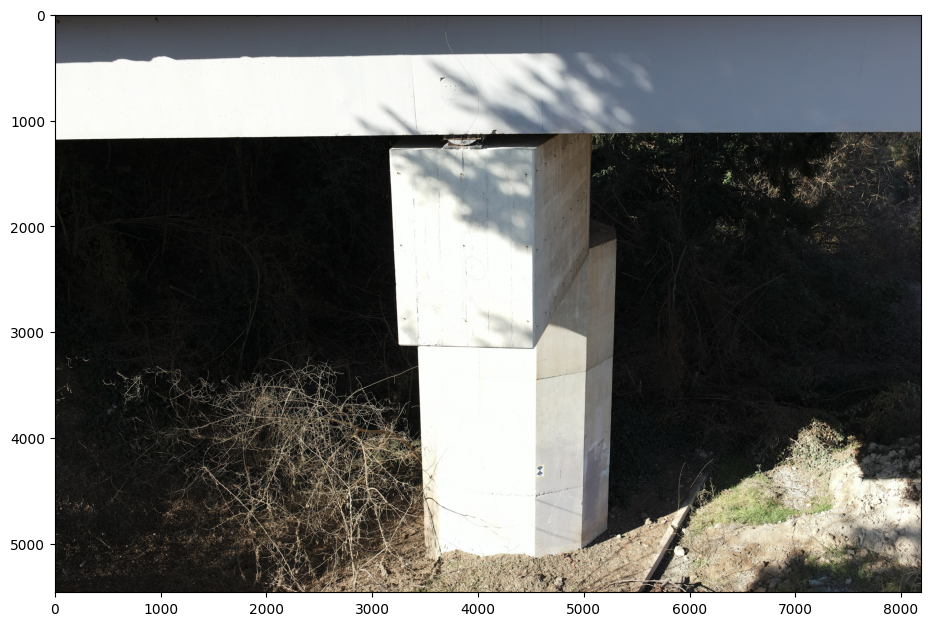

In [17]:
#camera view
img = cv.imread(IMAGE_PATH)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) 
plt.show()

Ray casting approach

In [18]:
image_shape = (img.shape[0], img.shape[1])  # (height, width) of the image

Total vertices: 7960


/tmp/ipykernel_56591/1193978331.py:13: RuntimeWarning:

invalid value encountered in cast



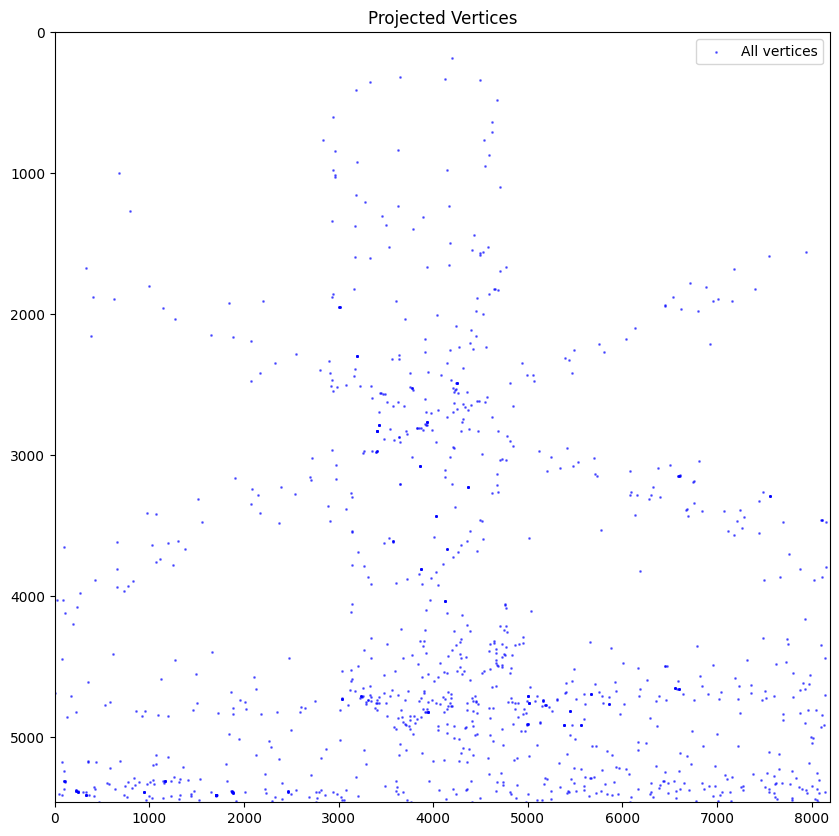

In [19]:


def world_to_camera(points, R, t):
    t = t.reshape(1, 3)
    return np.dot(points - t, R.T)


# use trimesh to project
def project_points(vertices, rotation, center, camera_matrix, dist_coeffs):
    tvec = -np.matmul(rotation, center)
    rvec, _ = cv.Rodrigues(rotation) #use rotation matrix
    pixels_projected, _ = cv.projectPoints(vertices.astype(np.float32), rvec.astype(np.float32), tvec.astype(np.float32), camera_matrix.astype(np.float32), dist_coeffs.astype(np.float32))
    pixels_projected = pixels_projected.squeeze().astype(np.int32)
    return pixels_projected


def get_vertices_image(mesh, R, t, K, dist_coeffs, image_size):
    vertices = np.asarray(mesh.vertices)
    print(f"Total vertices: {len(vertices)}")
    vertices_image = project_points(vertices, R, t, K, dist_coeffs)
    return vertices_image


def visualize_projected(vertices_image, image_size):
    plt.figure(figsize=(10, 10))
    plt.scatter(vertices_image[:, 0], vertices_image[:, 1], c='blue', s=1, alpha=0.5, label='All vertices')
    # plt.scatter(vertices_image[visible_vertices, 0], vertices_image[visible_vertices, 1], c='red', s=5, label='Visible vertices')
    plt.xlim(0, image_size[1])
    plt.ylim(image_size[0], 0)  # Invert y-axis to match image coordinates
    plt.legend()
    plt.title('Projected Vertices')
    plt.show()

# Call this function after get_visible_vertices
visualize_projected(get_vertices_image(pier, rotation, center, camera_matrix, dist_coeffs, image_shape), image_shape)

In [20]:
import PIL.Image
ray = trimesh.ray.ray_pyembree


def visible_points1(mesh, potential_indices, camera_position, vertices, image_shape, camera_matrix):


    ray_origins = np.tile(camera_position, (len(potential_indices), 1))
    ray_directions = vertices[potential_indices] - camera_position
    ray_directions /= np.linalg.norm(ray_directions, axis=1)[:, np.newaxis]

    intersector = ray.RayMeshIntersector(mesh)
    ray_idxs = intersector.intersects_id(ray_origins, ray_directions, multiple_hits=False)[1]
    visible_indices =  potential_indices[ray_idxs]
    visible_vertices = vertices[visible_indices] 
    # vertices_image = project_points(mesh, R, t, K, dist_coeffs)
    # img = np.zeros(image_shape[::-1]).flatten()
    # img[ray_idxs] = 255
    # img = PIL.Image.fromarray(img.reshape(image_shape[::-1]))
    return visible_vertices, visible_indices



def get_potential_indices(mesh, R, t, K, dist_coeffs, image_size):
    vertices = np.asarray(mesh.vertices).astype(np.float32)
    print(f"Total vertices: {len(vertices)}")
    # Transform vertices to camera coordinates
    vertices_camera = world_to_camera(vertices, R, t)
    # Project vertices to image plane
    vertices_image = project_points(vertices, R, t, K, dist_coeffs)
    print(f"Vertices in camera coordinates shape: {vertices_camera.shape}")
    print(f"Vertices in image coordinates shape: {vertices_image.shape}")
    in_front_of_camera = vertices_camera[:, 2] > 0
    within_x_bounds = (vertices_image[:, 0] >= 0) & (vertices_image[:, 0] < image_size[1])
    within_y_bounds = (vertices_image[:, 1] >= 0) & (vertices_image[:, 1] < image_size[0])
    within_image_bounds = within_x_bounds & within_y_bounds
    potentially_visible = in_front_of_camera & within_image_bounds
    print(f"Vertices in front of camera: {np.sum(in_front_of_camera)}")
    print(f"Vertices within image boundaries: {np.sum(within_image_bounds)}")
    print(f"Potentially visible vertices: {np.sum(potentially_visible)}")
    potential_indices = np.where(potentially_visible)[0]      
    return potential_indices


def get_visible_vertices(mesh, potential_indices, camera_position):
    vertices = np.asarray(mesh.vertices)
    visible_indices = visible_points(mesh, potential_indices, camera_position, vertices, image_shape, camera_matrix)
    print(f"Vertices passed occlusion check: {len(visible_indices)}")
    
    return visible_indices
    
camera_position_outer = -np.matmul(rotation, center).flatten()
# visible_indices = get_visible_vertices(pier, rotation, center, camera_matrix, dist_coeffs, image_shape[::-1])

Total vertices: 7960
Vertices in camera coordinates shape: (7960, 3)
Vertices in image coordinates shape: (7960, 2)
Vertices in front of camera: 7760
Vertices within image boundaries: 1304
Potentially visible vertices: 1304
LEN VERTS 1236


/tmp/ipykernel_56591/1193978331.py:13: RuntimeWarning:

invalid value encountered in cast



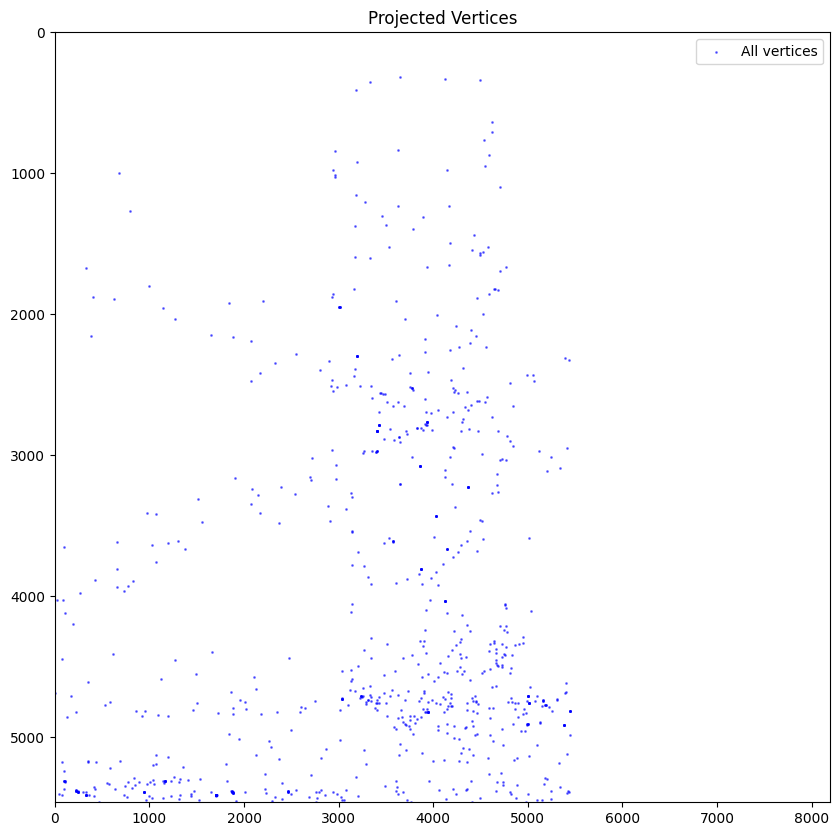

In [21]:
import cv2 
mesh = pier 

camera_position = -np.matmul(rotation, center).flatten()
potential_indices = get_potential_indices(pier, rotation, center, camera_matrix, dist_coeffs, image_shape[::-1])
vertices = np.asarray(mesh.vertices)

vertices_image = project_points(vertices, rotation, center, camera_matrix, dist_coeffs)

visible_vertices, visible_indices = visible_points1(mesh, potential_indices, camera_position, vertices, image_shape, camera_matrix)
visible_vertices = np.asarray(visible_vertices)
print('LEN VERTS', len(visible_vertices))



vertices_image = project_points(visible_vertices, rotation, center, camera_matrix, dist_coeffs)


visualize_projected(vertices_image, image_shape)

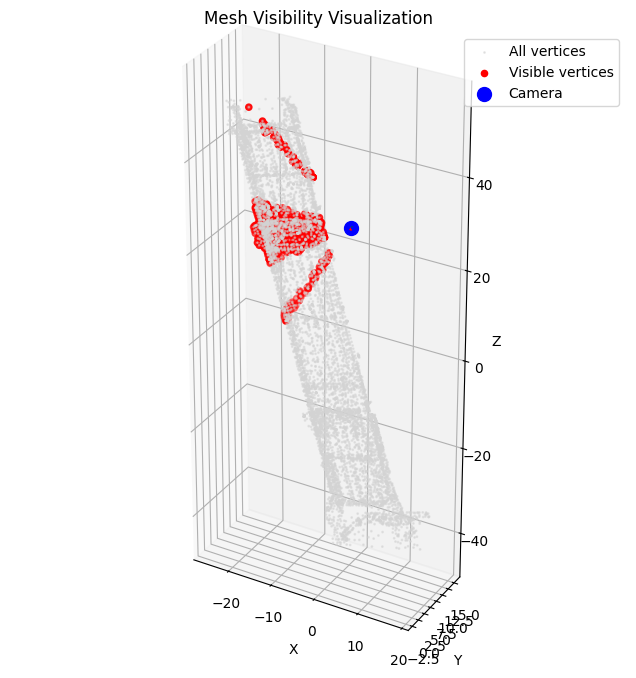

In [23]:
visualize_results(pier, visible_indices, center, rotation)

as we can see above, that vertices on the other side of the bridge marked as visible, which shouldn't be the case

In [24]:
camera_position = -np.matmul(rotation, center).flatten()
camera_position_fix = np.array([camera_position[1], camera_position[2], camera_position[0]])
visualize_results_interactive(pier, visible_indices, camera_position_fix, rotation, center)

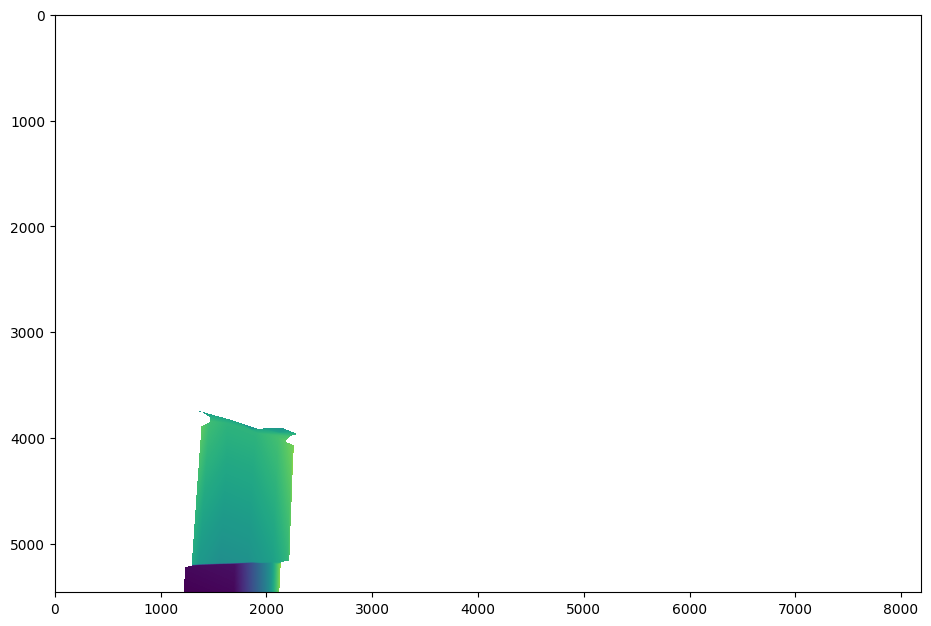

In [25]:
# open3d approach

def render_depth(
    intrins:o3d.core.Tensor,
    width:int,
    height:int,
    extrins:o3d.core.Tensor,
    tmesh:o3d.t.geometry.TriangleMesh
)->np.ndarray:
    
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(tmesh)
    rays = scene.create_rays_pinhole(
        intrinsic_matrix=intrins,
        extrinsic_matrix=extrins,
        width_px=width, height_px=height
    )
    ans = scene.cast_rays(rays)
    t_hit = ans["t_hit"].numpy()
    return t_hit


mesh_path = 'triangulated_decimated.obj'
mesh = o3d.t.io.read_triangle_mesh(mesh_path)
mesh.compute_vertex_normals()
width_  =  img.shape[1]
height_ = img.shape[0]
# root2cam 4x4
extrens = np.eye(4)
extrens[:3, :3] = rotation
extrens[:3, 3] = np.squeeze(center)

intrins_t = o3d.core.Tensor(camera_matrix)
extrins_t = o3d.core.Tensor(extrens)

rendered_depth = render_depth(
    intrins=intrins_t, 
    width=width_, 
    height=height_, 
    extrins = extrins_t, 
    tmesh=mesh
)

plt.imshow(rendered_depth)
plt.show()

In [26]:
center

array([[ 2.515417 ],
       [ 5.8314095],
       [29.673502 ]], dtype=float32)

same picture but in 3d 

not all visible verticies are selected